In [1]:
import os, sys, glob, numpy as np, matplotlib, scipy, healpy as hp, time
%matplotlib inline
from matplotlib import pyplot as plt, colors
from scipy import stats, interpolate, optimize
import numpy.lib.recfunctions as rf

In [2]:
# Load in both the simulation and the data
sim = np.load("../counting_analysis/data/IC86_2012_MC.npy")
data = np.load("../counting_analysis/data/IC86_2012_exp.npy")

# Reduce the number of events in the simulation
# to a manageable level.
N = len(sim)
n_keep = 10000
sim = np.random.choice(sim, n_keep)    # cut down to n_keep events
sim['ow'] /= float(n_keep)/float(N)    # correct the weights
print("Reduced the number of simulation events from ",
     "{} to {}".format(N, len(sim)))
print()

# Show the possible keys available here:
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Keys available in data:")
print(sorted(data.dtype.names))

Reduced the number of simulation events from  11595414 to 10000

Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [3]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl = np.load("../counting_analysis/data/GRL/IC86_2012_exp.npy")

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [4]:
# We will need the average rate for our analysis.
# We can get this by either counting the number of
# events in data or the number of events recorded
# in the GRL and dividing by the total good livetime.
total_events = len(data)
total_livetime = np.sum(grl['livetime'])

average_rate = total_events / total_livetime
print("Data has an average rate of {:4.2f} events/day".format(average_rate))

Data has an average rate of 339.96 events/day


In [5]:
# Define the parameters of our analysis.
# We're going to simplify things a little bit to start
# and ignore the impact of detector downtime, which
# would need to be included in an actual analysis.
# 
# Our first test analysis will look for an excess of 
# neutrino events in 1000 seconds across the entire sky.
time_window = 1000 # seconds
time_window /= (24*3600.) # converted to days, since our rate is in days.

# We will be using the data to model the background in
# our test analysis. How many background events should
# we expect in our analysis?
n_expected = average_rate * time_window
print("We expect an average of {:4.3f} background events in our "\
      "{:4.3f} day time window.".format(n_expected, time_window))

We expect an average of 3.935 background events in our 0.012 day time window.


In [6]:
# Write some helper functions that we can use 
# later. Specifically, we want to be able to 
# calculate the angular distance between two
# directions and to produce a trial including
# signal and background.
def to_unit_vector(ra, dec):
    return np.array([np.cos(ra)*np.cos(dec),
                     np.sin(ra)*np.cos(dec),
                     np.sin(dec)])

def angular_distance(ra_A, dec_A, ra_B, dec_B): 
    unit_A = to_unit_vector(ra_A, dec_A)
    unit_B = to_unit_vector(ra_B, dec_B)
    
    if len(unit_A.shape) != 1:
        return np.arccos(np.dot(unit_A.T, unit_B))
    else:
        return np.arccos(np.dot(unit_A, unit_B))


In [7]:
# We're going to use a "true" pdf for the signal: 
# We're just going to pick out events that have a
# true direction near to the source. This'll be used
# for when we want to add some signal to our trials
def true_signal_pdf(event,
                    source_ra, 
                    source_dec):
    distance = angular_distance(event['trueRa'], 
                                event['trueDec'], 
                                source_ra, 
                                source_dec)
    sigma = event['angErr']
    return (1.0)/(2*np.pi*sigma**2) * np.exp(-(distance)**2/(2*sigma**2))

# A trial is one simulated observation. In our case,
# our analysis is looking at 1000 second time windows
# which may have signal and background events. Define
# a function which can produce a trial for us.
# This time, we want to return the directional info
# for the selected events. To do this, we need to do
# some magic near the end of the function.
def produce_trial(n_background = n_expected,
                  N=0,
                  gamma=-2,
                  source_ra = np.pi/2,
                  source_dec = np.pi/6,
                  window = time_window,
                  data=data,
                  sim=sim,
                  random_seed = None):
    
    if random_seed != None:
        np.random.seed(random_seed)
        
    # We're here going to sample background events from
    # our data. This is a trick we use, since almost all
    # events from our data will be background. This saves
    # us from having to pick a background spectrum.
    n_background_observed = scipy.stats.poisson.rvs(n_background)
    background = np.random.choice(data, n_background_observed)
        
    # Do we want signal events?
    if N > 0:
        # Use what we know about weighting to pick events
        # from a power law. Here, I'm going to use a power
        # law with an index of -2 and E0 of 100 TeV
        weights = sim['ow'] *\
                  (N * (sim['trueE']/100.e3)**gamma) *\
                   window * 24*3600

        signal_p = true_signal_pdf(sim, source_ra, source_dec)
        signal_p /= np.sum(signal_p)

        n_signal_observed = scipy.stats.poisson.rvs(np.sum(weights))
        signal = np.random.choice(sim, n_signal_observed,
                                  p = signal_p)

        #print("added {} signal events".format(signal.shape[0]))

        # Because we want to return the entire event and not just the
        # number of events, we need to do some numpy magic. Specifically,
        # we need to remove the fields in the simulated events that are
        # not present in the data events. These include the true direction,
        # energy, and 'oneweight'.
        signal = rf.drop_fields(signal, [n for n in signal.dtype.names \
                                         if not n in background.dtype.names])
    else:
        signal = np.empty(0, dtype=background.dtype)
    return np.concatenate([background, signal])

In [8]:
# Produce a single trial. Here, we pass a "seed"
# value to the function so that we can reproduce
# the trial later if we want to. If you want it to
# be random, set seed=None.
seed = 0
trial = produce_trial(N=2e-15, random_seed=seed)
print("Got {} events for this trial".format(len(trial)))
print(trial)
print(trial.dtype.names)

Got 12 events for this trial
[(    121751, 17568598, 0, 2.30680808, -0.61891759, 3.23841328, 0.95089633, 56315.29186733, 5.22005328, 0.00671682)
 (    120796, 47200058, 0, 4.92617801, -0.24786577, 4.59252033, 1.32327035, 56211.20936199, 3.59446253, 0.00153484)
 (    120667, 34861498, 0, 3.99078764,  0.19244637, 2.00954121, 1.76239926, 56183.72456093, 3.04826327, 0.01302006)
 (    120849, 40407048, 0, 2.52312287,  0.32456057, 0.55874837, 1.8943615 , 56223.15219616, 2.80203533, 0.00919334)
 (    121715, 65504829, 0, 5.53648497, -0.18466367, 1.1664483 , 1.38707229, 56312.48391779, 4.55083719, 0.01699111)
 (    120420, 61021683, 0, 0.74340587, -0.30195675, 2.46160594, 1.26968149, 56115.46654026, 4.55688186, 0.00652001)
 (1106903367,     4041, 0, 1.5933146 ,  0.51920843, 1.8443856 , 2.08989461, 55927.01967593, 3.02105763, 0.0171651 )
 (1106903367,     4041, 0, 1.5933146 ,  0.51920843, 1.8443856 , 2.08989461, 55927.01967593, 3.02105763, 0.0171651 )
 (1102903296,   136470, 0, 1.29342135,  0.5

In [9]:
# Our signal PDF at this stage consists of just
# a spatial part. In the case of the current dataset,
# a Gaussian spatial PDF will work. In the case where
# your angular unceratinties ("angErr") get larger
# than a couple of degrees, you should probably use
# a von-Mises distribution instead.
def signal_pdf(event,
               test_ra, 
               test_dec):    
    sigma = event['angErr']
    x = angular_distance(event['ra'], event['dec'], 
                         test_ra, test_dec)
    
    return (1.0/(2*np.pi*sigma**2))*np.exp(-x**2/(2*sigma**2))

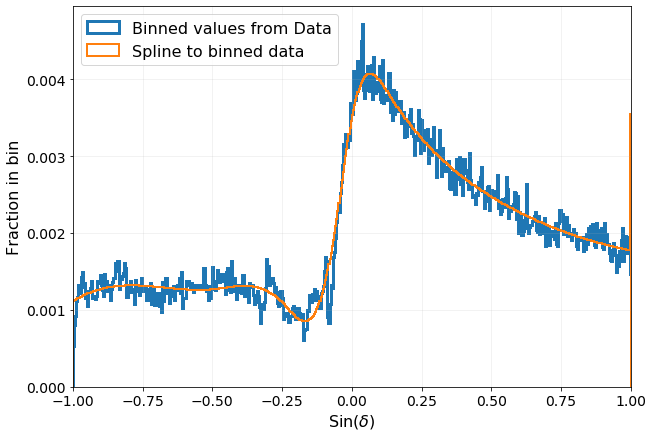

In [10]:
# Our background PDF only depends on declination.
# In order for us to capture the dec-dependent
# behavior, we first take a look at the dec values
# in the data. We can do this by histogramming them.
fig, ax = plt.subplots(figsize=(10, 7))

sin_dec = np.sin(data['dec'])
bins = np.linspace(-1.0, 1.0, 501)

# Make the background histogram. Note that we do NOT
# want to use density=True here, since that would mean
# that our spline depends on the original bin widths!
hist, bins, _ = ax.hist(sin_dec, 
                        bins=bins, 
                        histtype='step', 
                        linewidth=3,
                        weights=np.ones_like(data['dec'])/len(data['dec']),
                        label='Binned values from Data')

# These values have a lot of "noise": they jump
# up and down quite a lot. We could use fewer
# bins, but that may hide some features that
# we care about. We want something that captures
# the right behavior, but is smooth and continuous.
# The best way to do that is to use a "spline",
# which will fit a continuous and differentiable
# piecewise polynomial function to our data. 
# We can set a smoothing factor (s) to control
# how smooth our spline is.
bg_p_dec = interpolate.UnivariateSpline(bins[:-1]+np.diff(bins)/2., 
                                        hist,
                                        bbox=[-1.0, 1.0],
                                        s=1.5e-5,
                                        ext=1)

# Plot this too, so we can see how it compares
# to the histogram.
bg_p_dec_hist, bins, _ = ax.hist(bins, 
                                 bins=bins,
                                 weights=bg_p_dec(bins), 
                                 histtype='step',
                                 linewidth=2,
                                 label = 'Spline to binned data')

ax.legend(loc='upper left', fontsize=16)
ax.grid(alpha=0.2)
ax.set_xlim(-1, 1)
ax.set_xlabel(r'Sin($\delta$)', fontsize=16,)
ax.set_ylabel("Fraction in bin", fontsize=16)
ax.tick_params(labelsize=14)

In [11]:
# To get the declination-dependent background PDF,
# we can now just call the background spline. Note
# that we splined in sin(dec), so we need to pass
# that to the spline. 
def background_pdf(event,
                   test_ra, 
                   test_dec):
    background_likelihood = (1/(2*np.pi))*bg_p_dec(np.sin(event['dec']))
    return background_likelihood

In [41]:
# Our events will consist of some unknown combination
# of signal events (described by the PDF "signal_pdf", S)
# and background events (described by "background_pdf", B).
# We'll call the number of signal events ns.
# Then the total likelihood will therefore be 
#
# L_i = (ns/N)*S + (nb/N)*B
#     = (ns/N)*S + ((N-ns)/N)*B
#
# which we will sum over all events i in our trial.
# We'll evaluate these at a "test point" in RA, dec.
def spatial_llh(event,
                test_ra,
                test_dec,
                ns = 0,
                minimize = True):
    N = len(event)
    if N==0: 
        return 0, [-1,]
    
    # Check: ns cannot be larger than N.
    if ns > N: 
        ns = N - 0.0001

    S = signal_pdf(event, test_ra, test_dec)
    B = background_pdf(event, test_ra, test_dec)
    
    def get_ts(ns):
        ts = (ns/N*(S/B-1))+1
        return -2*np.sum(np.log(ts))
    
    if minimize:
        result = scipy.optimize.minimize(get_ts,
                                         x0 = [ns,],
                                         bounds = [[0, N],],
                                         method = 'SLSQP',
                                         tol = 1e-5,)
        return -1*result.fun, result.x
    
    else:
        return -1*get_ts(ns), [ns,]

In [42]:
# Write a function that can produce our
# trials for us. This'll help when we need
# to calculate our sensitivities, since we'll
# need to call this a lot.
def produce_n_trials(ntrials,
                        
                     # Parameters to control the true signal, background
                     n_background = n_expected, 
                     N=0, 
                     gamma=-2, 
                     source_ra = np.pi/2, 
                     source_dec = np.pi/6, 
                     
                     # Parameters to control where/when you look
                     test_ns = 0,
                     test_ra = np.pi/2,
                     test_dec = np.pi/6,
                     window = time_window, 
                     
                     # The data to use
                     data=data, 
                     sim=sim, 
                     
                     minimize = True,
                     random_seed = None,
                     verbose=True):
    
    llhs = []
    fit_info = {'ninj':[], 'ns':[],}
    for i in range(ntrials):
        # Get the events for this trial.
        trial = produce_trial(n_background=n_expected, 
                               N=N, 
                               gamma=gamma, 
                               source_ra=source_ra, 
                               source_dec=source_dec, 
                               window=time_window, 
                               data=data, 
                               sim=sim, 
                               random_seed = random_seed)

        # How many signal events were actually
        # injected?
        ninj = (trial['run']>200000).sum()
        
        # And the likelihood for the trial
        llh, bestfit = spatial_llh(trial, 
                                  test_ra, 
                                  test_dec,
                                  ns = test_ns,
                                  minimize = minimize,
                                  )
        
        fit_info['ninj'].append(ninj)
        fit_info['ns'].append(bestfit[0])
        
        llhs.append(llh)
    return llhs, fit_info
    
# Run trials for a few different values of N.
# Here, I'll assume ns=1 for all cases.
background_ts, background_info = produce_n_trials(1000, test_ns=0, minimize=True)
signal_16, signal_16_info = produce_n_trials(500, N=1e-16, test_ns=0, minimize=True)
signal_15, signal_15_info = produce_n_trials(500, N=1e-15, test_ns=0, minimize=True)
signal_14, signal_14_info = produce_n_trials(500, N=1e-14, test_ns=0, minimize=True)

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


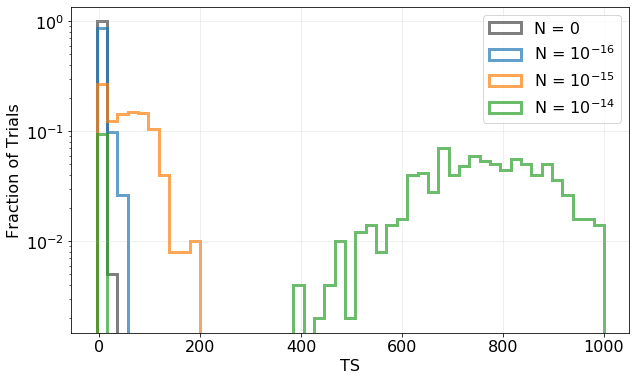

In [43]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-5, 1000, 50)

ax.hist(background_ts,
        bins = bins,
        weights = np.ones_like(background_ts)/len(background_ts),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16,
        bins = bins,
        weights = np.ones_like(signal_16)/len(signal_16),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15,
        bins = bins,
        weights = np.ones_like(signal_15)/len(signal_15),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14,
        bins = bins,
        weights = np.ones_like(signal_14)/len(signal_14),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log


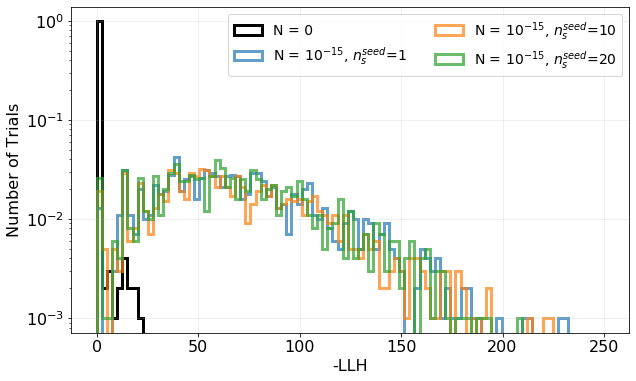

In [53]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 250, 100)

ax.hist(background_ts,
        bins = bins,
        weights = np.ones_like(background_ts)/len(background_ts),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        label = r'N = 0')

for ns in [1, 10, 20]:
    signal_ts, _ = produce_n_trials(1000, 
                                 N=1e-15, 
                                 test_ns=ns,
                                minimize=True,)
    ax.hist(signal_ts,
        bins = bins,
        weights = np.ones_like(signal_ts)/len(signal_ts),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$, $n^{seed}_s$' + '={}'.format(ns))

ax.legend(loc='upper right', ncol=2, fontsize=14,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("-LLH", fontsize=16)
ax.set_ylabel("Number of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

3 0


/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


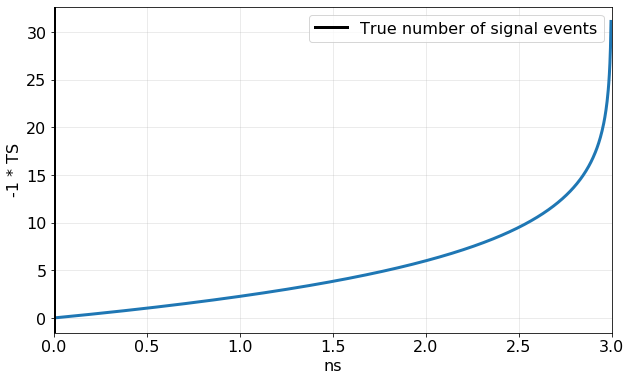

In [46]:
# Produce a single trial that we can use to answer the
# question "What does the TS look like as a function of ns?"
trial = produce_trial(N=0)

# How many signal events are there really in this trial?
# Use a trick of this dataset to ID signal events.
# This works since the simulated events have the
# runs set to very large numbers while the data
# (our background events) have values below 200,000.
ns_true = (trial['run']>200000).sum()
print(len(trial['run']), ns_true)

ns_values = np.linspace(0, len(trial), 1000)
ts_values = []
for ns in ns_values:
    # Calculate the spatial LLH for this ns and trial
    # How do we call the spatial likelihood for this
    # trial and ns with a source at RA=pi/2, dec=pi/6?
    llh, _ = spatial_llh(trial,
                      np.pi/2,
                      np.pi/6,
                      ns = ns,
                      minimize = False,)
    ts_values.append(llh)

# numpy arrays are easier to do calculations with than lists
ts_values = np.array(ts_values)
    
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
fig, ax = plt.subplots(figsize=(10,6))

# Add your plotting line here
ax.plot(ns_values, 
        -1*ts_values,
        linewidth=3,)

ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = 'True number of signal events')

ax.grid(alpha=0.3)
ax.set_xlim(ns_values.min(), ns_values.max())
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("-1 * TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

/Users/mjlarson/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.


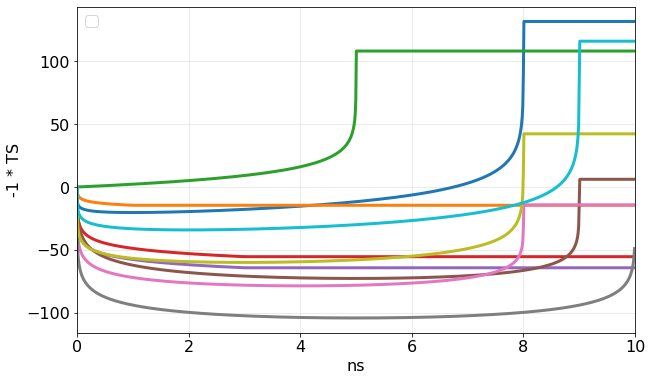

In [48]:
# Plot -1*LLH vs ns for this trial
# Note that we're going to plot -1*LLH here.
fig, ax = plt.subplots(figsize=(10,6))

for i in range(10):
    # Produce a single trial that we can use to answer the
    # question "What does the TS look like as a function of ns?"
    trial = produce_trial(N=1e-15)

    ns_values = np.linspace(0, 10, 1000)
    ts_values = []
    for ns in ns_values:
        # Calculate the spatial LLH for this ns and trial
        # How do we call the spatial likelihood for this
        # trial and ns with a source at RA=pi/2, dec=pi/6?
        llh, _ = spatial_llh(trial,
                              np.pi/2,
                              np.pi/6,
                              ns = ns,
                            minimize = False,)
        ts_values.append(llh)

    # numpy arrays are easier to do calculations with than lists
    ts_values = np.array(ts_values)

    # Add your plotting line here
    ax.plot(ns_values, 
            -1*ts_values,
            linewidth=3,)

ax.grid(alpha=0.3)
ax.set_xlim(ns_values.min(), ns_values.max())
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("-1 * TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)